## Import Common Packages

In [4]:
import pandas as pd
import numpy as np

import _pickle as pickle
from collections import Counter
from pprint import pprint
from datetime import datetime
import shutil
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## ~~Loading from training data directory (supports batch mode)~~

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import DatasetFolder

In [ ]:
# TRAIN_DIR = '../training_data/'

In [ ]:
# from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import DatasetFolder

# def pickle_loader(input_path):
#     f = open(input_path, 'rb')
#     data = pickle.load(f)

#     return { 'segment': data[0], 'label': data[1] }
# #     return data[0], data[1]


# # TODO: decide on what transformation to perform
# def transform_input(input):
#     """
#     Transform input so that all input samples in the batch have same size.
#     Note: this is not required if the batch size is 1 for the data loader.
#     """
#     num_frames = 3
    
#     return { 'segment': input['segment'][:num_frames], 'label': input['label'] }
# #     return input[:num_frames]

In [ ]:
# # https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder
# # Directory should be 'TRAIN_DIR/data/*.doc'
# train_data = DatasetFolder(root=TRAIN_DIR, 
#                            loader=pickle_loader, 
#                            extensions='.doc', 
#                            transform=transform_input
#                           )

# train_loader = torch.utils.data.DataLoader(dataset=train_data,
#                                            batch_size=4,
#                                            num_workers=0,
#                                            shuffle=False
#                                           )

# for batch_idx, batch_data in enumerate(train_loader):
#     input_samples = batch_data[0]['segment'] # Same length as batch size
#     input_labels = batch_data[0]['label']

# #     x = Variable(input_samples)
# #     out = model(x)
# # https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

## Loading from single training data file

In [5]:
ROOT_DIR = "../"#"/content/drive/My Drive/" # "../"

DATA_DIR = ROOT_DIR
RESULTS_DIR = ROOT_DIR + "results/"

TRAINING_DATA = DATA_DIR + "training_data.p"
VALIDATION_DATA = DATA_DIR + "validation_data.p"
TEST_DATA = DATA_DIR + "testing_data.p"

### Data Analysis

#### TODO: decide on batch sizes, and sort input data by segment lengths + validation dataset

Store file pointer position as `{ segment_idx: file_ptr_offset }`.

Then use `seek()` to read segment from the offset position to create the new data file which is sorted by segment length.

In [19]:
f = open(TRAINING_DATA, 'rb')

labels = []
segment_lengths = []
segment_idx = 0
while True:
    try:
        (segment, label) = pickle.load(f)
        
        labels.append(label)
        segment_lengths.append((segment_idx, len(segment)))
        segment_idx += 1
    except (EOFError):
        break

f.close()

print(segment_idx)
sorted_segment_lengths = sorted(segment_lengths, key=lambda tup: tup[1])
lengths = [seg_len[1] for seg_len in segment_lengths]

df = pd.DataFrame({'seg_len': lengths})
display(df.describe())

length_counts = Counter(lengths)
# pprint(sorted(counts.items(), key=lambda i: i[0]))

5660


,seg_len
count,5660.000000
mean,407.330389
std,554.839000
min,8.000000
25%,133.000000
50%,235.000000
75%,432.000000
max,5791.000000


Text(0, 0.5, 'Frequency')

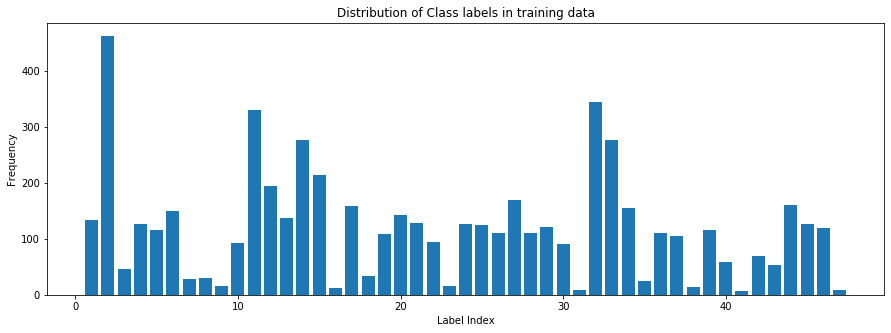

In [20]:
fig = plt.figure(figsize=(15,5))

# plt.hist(labels, bins=150)
label_counts = Counter(labels)
plt.bar(label_counts.keys(), label_counts.values())

plt.gca().set_title('Distribution of Class labels in training data')
plt.xlabel('Label Index')
plt.ylabel('Frequency')

Text(0, 0.5, 'Number of segments (frequency)')

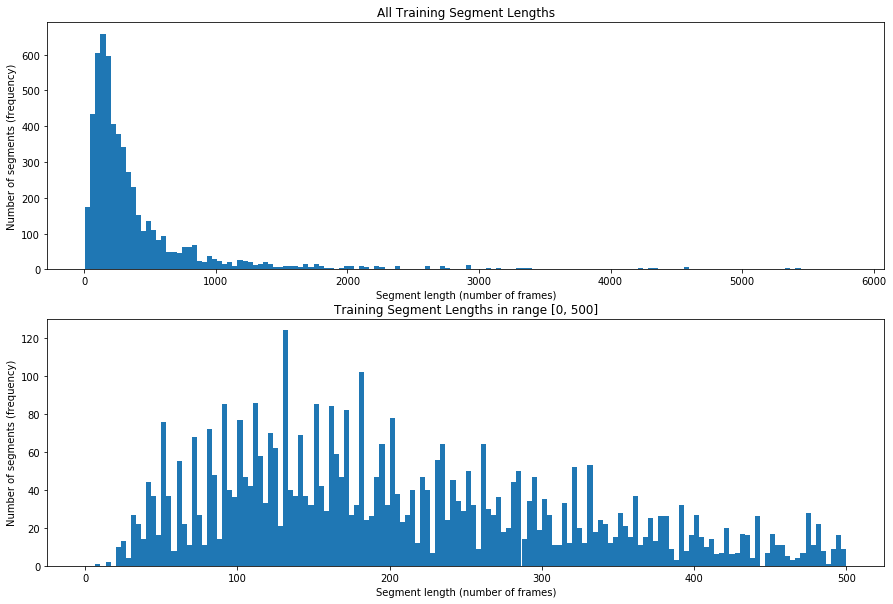

In [21]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.hist(lengths, bins=150)
# plt.bar(length_counts.keys(), length_counts.values())

plt.gca().set_title('All Training Segment Lengths')
plt.xlabel('Segment length (number of frames)')
plt.ylabel('Number of segments (frequency)')

plt.subplot(2, 1, 2)
plt.hist(lengths, bins=150, range=[0, 500])

plt.gca().set_title('Training Segment Lengths in range [0, 500]')
plt.xlabel('Segment length (number of frames)')
plt.ylabel('Number of segments (frequency)')

## Simple RNN Model

- [Pytorch RNN](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/#step-3-create-model-class)
- [Tensorflow Keras RNN](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/keras/rnn.ipynb) 

In [9]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [10]:
def transform_input(segments):
    """
    Transform input with zero padding so that all input segments 
    in the batch have same size.
    """
    input_dim = 400 # num features in an i3D frame
    segment_lengths = [len(segments) for segments in segments]
    
    # Create an empty matrix with zero padding
    longest_segment = max(segment_lengths)
    batch_size = len(segments)
    padded_segments = np.zeros((batch_size, longest_segment, input_dim))
    
    # Copy over the actual frame sequences
    for i, length in enumerate(segment_lengths):
        sequence = segments[i]
        padded_segments[i, 0:length] = sequence[:length]
    
    # Change back to tensor of type double
    transformed_segments = []
    for padded_segment in padded_segments:
        transformed_segments.append(torch.Tensor(padded_segment).double())
    
    return transformed_segments

In [52]:
def get_next_data_batch(f, batch_size):    
    raw_segments = []
    labels = []
    
    is_end_reached = False
    
    num_segments = 0
    while num_segments < batch_size:
        try:
            (segment, label) = pickle.load(f)
            
            raw_segments.append(segment)
            labels.append(label)
            num_segments += 1
        except (EOFError):
            is_end_reached = True
            break
    
    if len(raw_segments) == 0:
        return [], [], is_end_reached
    
    padded_segments = transform_input(raw_segments)
    segments = torch.stack(padded_segments).double()
    labels = torch.Tensor(labels).long()
    
    return segments, labels, is_end_reached

In [12]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, segment_len, input_dim)

        # Initialize hidden state with zeros: (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).double().requires_grad_()

        # Detach hidden state to prevent exploding/vanishing gradients (Truncated BPTT)
        # rnn_out: (batch_size, time_step, output_dim)
        rnn_out, hn = self.rnn(x, h0.detach())

        # Predict using hidden states of last time step  
        # out: (batch_size, output_dim)
        out = self.fc(rnn_out[:, -1, :]) 

        return out

# Train Model

In [17]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

def train_model(model, batch_sizes, num_epochs=10, train_data_file=TRAINING_DATA, validation_data_file=VALIDATION_DATA):
    training_losses = []
    validation_losses = []

    
    for epoch in range(num_epochs):
        start = time.time()
        print('======================================================================')
        print('Epoch: {}'.format(epoch))

        try:
            train_f.close()    
        except(NameError):
            ;   
        
        train_f = open(train_data_file, 'rb')
        should_epoch_end = False

        iter = 0
        epoch_training_losses = []

        # for i, (segments, labels) in get(train_loader):        
        while not should_epoch_end:
            model.train()
            
            batch_size = 100 # TODO: use batch_sizes instead
            # batch_size = batch_sizes[iter] # Use variable batch sizes
            segments, labels, should_epoch_end = get_next_data_batch(train_f, batch_size)
            if len(segments) == 0:
                break
            
            # Load segments as tensors with gradient accumulation abilities
            segments = segments.requires_grad_()

            optimizer.zero_grad()

            outputs = model(segments)

            loss = loss_criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            epoch_training_losses.append(loss.item())

            iter += 1
            if iter % 10 == 0:
                print('    Iteration: {}. Loss: {}.'.format(iter, loss.item())) 

    
        train_f.close()            
        
        # Evaluate on validation set
        try:
            val_f.close()    
        except(NameError):
            ;  
            
        val_f = open(validation_data_file, 'rb')
        model.eval()

        correct = 0
        total = 0
        is_file_end = False

        epoch_validation_losses = []
        while not is_file_end:
            batch_size = 100 # TODO: use batch_sizes instead
            # batch_size = batch_sizes[iter] # Use variable batch sizes
            
            segments, labels, is_file_end = get_next_data_batch(val_f, batch_size)
            if len(segments) == 0:
                break
        
            outputs = model(segments)
            
            loss = loss_criterion(outputs, labels)
            epoch_validation_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum()
        
        val_f.close()
        

        accuracy = 100 * correct / total
        
        # Print loss
        training_losses.append(np.mean(epoch_training_losses))
        validation_losses.append(np.mean(epoch_validation_losses))

        scheduler.step(validation_losses[-1])

        print(f' Training Loss: {training_losses[-1]} Validation Loss: {validation_losses[-1]} Validation Accuracy: {accuracy}')
        end = time.time()
        print(f'Epoch took {end - start} seconds')
        
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, RESULTS_DIR + model_time + '/model_checkpoint.pth')
        
    return training_losses, validation_losses

In [18]:
model_time = str(datetime.now().strftime("%Y-%m-%d_%I-%M-%S"))
os.mkdir(model_time)

## Model Architecture
input_dim = 400  # dimension of an i3D video frame
hidden_dim = 100 # dimension of RNN hidden state
layer_dim = 1    # number of hidden RNN layers
output_dim = 48  # number of sub-action labels

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
model = model.double() # transform the model parameters to double precision


## Loss function
loss_criterion = nn.CrossEntropyLoss()


## Optimizer
learning_rate = 0.01
weight_decay = 0.002
momentum = 0.9

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


## Learning Rate Scheduler
patience = 3
decrease_factor = 0.5
min_learning_rate = 0.00005
scheduler = ReduceLROnPlateau(optimizer, mode='min', 
                              patience=patience, min_lr=min_learning_rate, factor=decrease_factor,
                              verbose=True)


num_epochs = 3

training_losses, validation_losses = train_model(model, batch_sizes=[], num_epochs=num_epochs) # TODO: batch_sizes

path = RESULTS_DIR + model_time + "/rnn_model.pth"
torch.save(model.state_dict(), path)
print("\nSaved trained model to", path)

Epoch: 0
    Iteration: 10. Loss: 4.7105998752786284.
    Iteration: 20. Loss: 3.791323129504601.
    Iteration: 30. Loss: 3.730759178643469.
    Iteration: 40. Loss: 3.7994009751587696.
    Iteration: 50. Loss: 3.862946122577028.
 Training Loss: 3.955994411511293 Validation Loss: 3.749188850080361 Validation Accuracy: 8
Epoch took 289.8275079727173 seconds
Epoch: 1
    Iteration: 10. Loss: 3.6781462286192768.
    Iteration: 20. Loss: 3.617930586371567.
    Iteration: 30. Loss: 3.848693893220051.
    Iteration: 40. Loss: 3.6653867481694937.
    Iteration: 50. Loss: 3.7647621531480193.
 Training Loss: 3.726096523804803 Validation Loss: 3.644752837894829 Validation Accuracy: 6
Epoch took 274.07900190353394 seconds
Epoch: 2
    Iteration: 10. Loss: 3.7010666719399428.
    Iteration: 20. Loss: 3.599485831179719.
    Iteration: 30. Loss: 3.703170956856697.
    Iteration: 40. Loss: 3.612751601737803.
    Iteration: 50. Loss: 3.643353947100289.
 Training Loss: 3.6727668805469427 Validation Lo

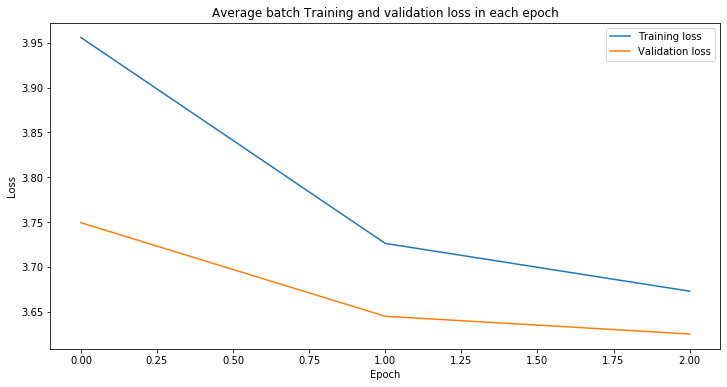

In [23]:
# Plot training and validation losses
# training_losses = training_losses.mean()
# validation_losses = validation_losses.mean()

plt.figure(figsize=(12,6))
plt.title("Average batch Training and validation loss in each epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend(["Training loss","Validation loss"])

In [ ]:
# # Load saved checkpoint
# checkpoint_path = RESULTS_DIR + "2020-03-21-_04-30-14" + "/model_checkpoint.pth"
# checkpoint = torch.load(checkpoint_path)

# epoch = checkpoint['epoch']
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])

# print("=> loaded checkpoint '{}' (epoch {})".format(checkpoint_path, epoch))

# # # Load saved model
# # path = RESULTS_DIR + "2020-03-21-_04-30-14" + "/rnn_model.pth"
# # model.load_state_dict(torch.load(path))

# Evaluation Results (on validation data)

In [53]:
model.eval()

try:
    val_f.close()    
except(NameError):
    ;   
val_f = open(VALIDATION_DATA, 'rb')

y = {'Actual': [], 'Predicted': []}

is_end_reached = False
while not is_end_reached:
    segments, labels, is_end_reached = get_next_data_batch(val_f, 1)
    
    if len(segments) == 0:
        break
    
    outputs = model(segments)
    _, predicted = torch.max(outputs.data, 1)
    
    y['Actual'].extend(labels.tolist())
    y['Predicted'].extend(predicted.tolist())
    
y_df = pd.DataFrame(y)
path = RESULTS_DIR + model_time + "/prediction_results.csv"        
y_df.to_csv(path, encoding='utf-8', index=False)

print('Done predicting on validation set')

Text(0, 0.5, 'Frequency')

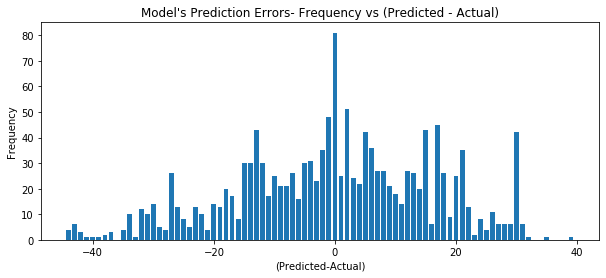

In [54]:
fig = plt.figure(figsize=(10,4))

y_err = np.subtract(y['Predicted'], y['Actual'])
err_counts = Counter(y_err)

plt.bar(err_counts.keys(), err_counts.values())
plt.gca().set_title("Model's Prediction Errors- Frequency vs (Predicted - Actual)")
plt.xlabel('(Predicted-Actual)')
plt.ylabel('Frequency')

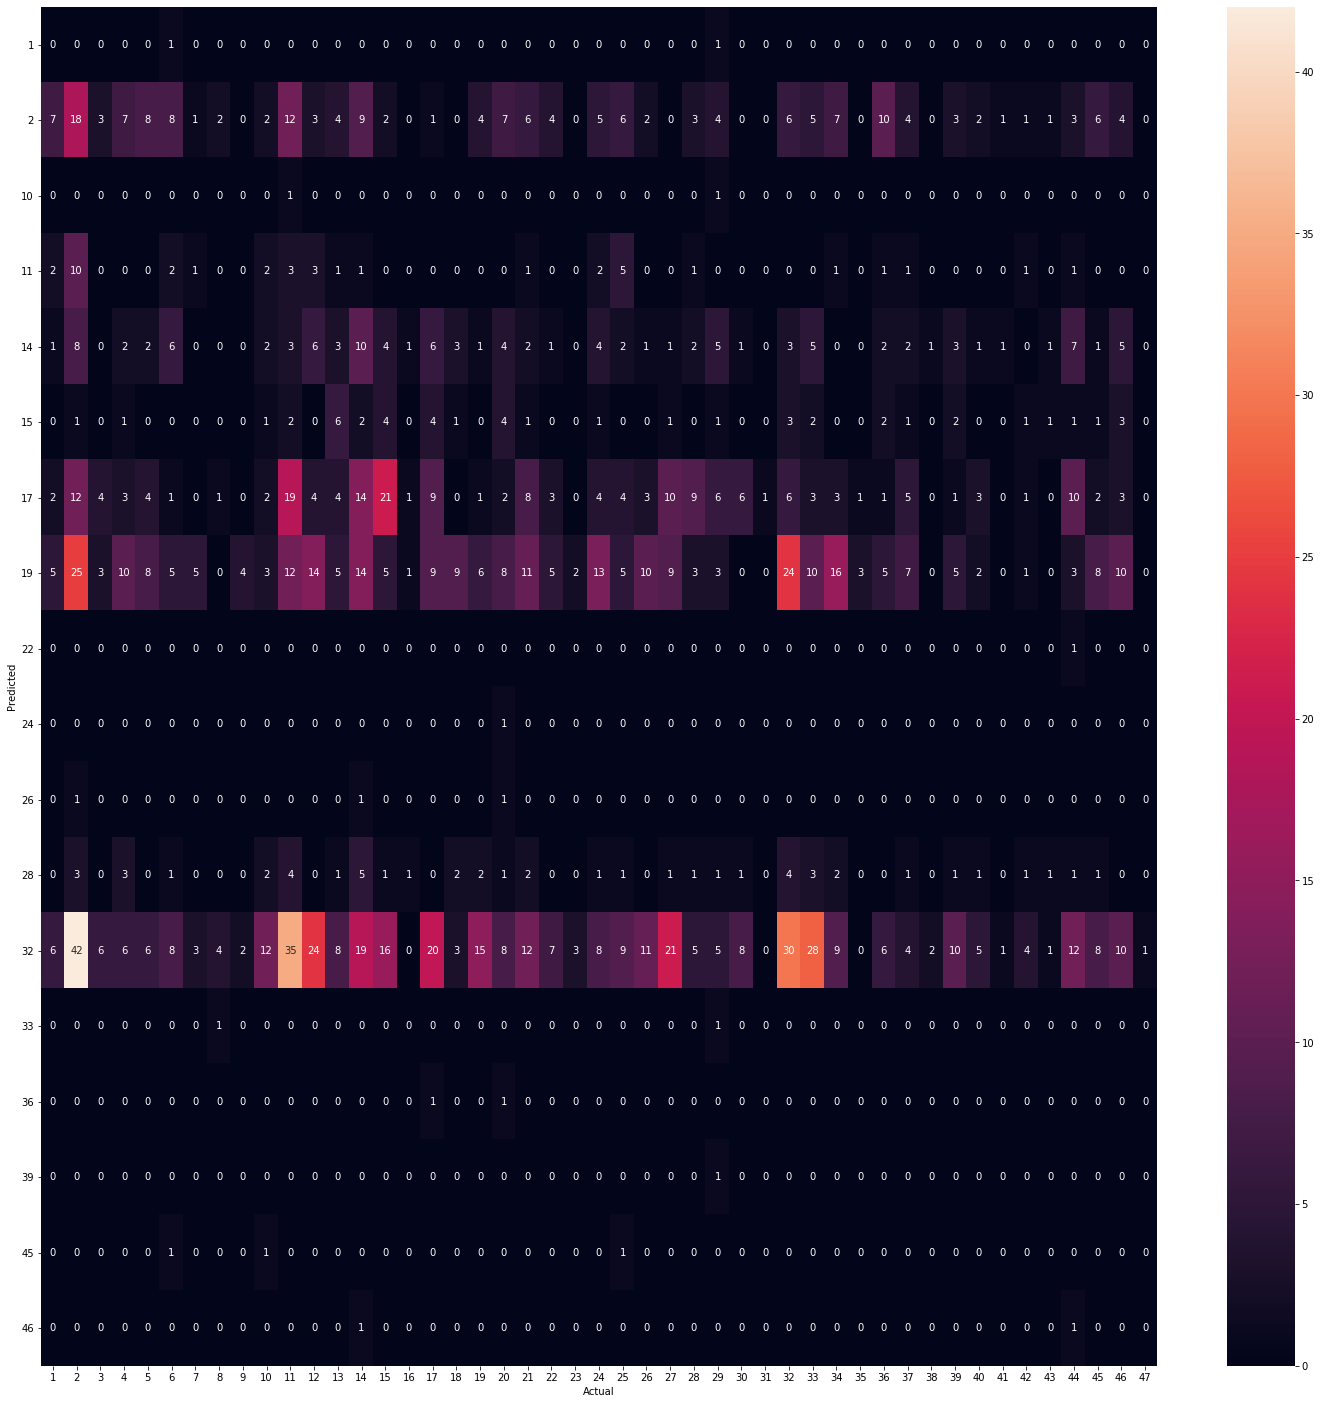

In [35]:
contingency_df = pd.crosstab(y_df['Predicted'], y_df['Actual'])
# display(contingency_df)

fig = plt.figure(figsize=(25,25))

g = sns.heatmap(contingency_df, annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation = 0);

In [55]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

print('\nMacro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="macro"))
print('Macro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="macro"))
print('Macro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="macro")) 

print('\nMicro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="micro"))
print('Micro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="micro"))
print('Micro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="micro")) 

print('\nAccuracy: %.4f' % accuracy_score(y['Actual'], y['Predicted']))

# Computes the average AUC of all possible pairwise combinations of classes. 
# Insensitive to class imbalance when average == 'macro'.
# print(roc_auc_score(y['Actual'], y['Predicted'], multi_class='ovo', average='macro')) 


Macro f1 Score= 0.0127
Macro Precision= 0.0106
Macro Recall= 0.0258

Micro f1 Score= 0.0572
Micro Precision= 0.0572
Micro Recall= 0.0572

Accuracy: 0.0572


In [37]:
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

report_with_auc = class_report(y_true=np.array(y['Actual']),y_pred=np.array(y['Predicted']))
display(report_with_auc)

C:\Users\amrut\.conda\envs\fyp\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,pred
1,0.000000,0.000000,0.000000,23.0,2.0
2,0.099448,0.150000,0.119601,120.0,181.0
10,0.000000,0.000000,0.000000,27.0,2.0
11,0.076923,0.032967,0.046154,91.0,39.0
14,0.088496,0.131579,0.105820,76.0,113.0
15,0.085106,0.075472,0.080000,53.0,47.0
17,0.045685,0.180000,0.072874,50.0,197.0
19,0.019608,0.206897,0.035821,29.0,306.0
22,0.000000,0.000000,0.000000,20.0,1.0
24,0.000000,0.000000,0.000000,38.0,1.0


## Make predictions on unseen test data (i.e. Kaggle submission)

In [40]:
NUM_TEST_SEGMENTS = 1284

def get_next_test_batch(f, batch_size=1):    
    raw_segments = []
    
    is_end_reached = False
    
    num_segments = 0
    while num_segments < batch_size:
        try:
            segment = pickle.load(f)
            
            raw_segments.append(segment)
            num_segments += 1
        except (EOFError):
            is_end_reached = True
            break

    padded_segments = transform_input(raw_segments)
    segments = torch.stack(padded_segments).double()
    
    return segments, is_end_reached


model.eval()

try:
    test_f.close()    
except(NameError):
    ;   
test_f = open(TEST_DATA, 'rb')

y_pred = {'Id': np.arange(NUM_TEST_SEGMENTS), 'Category': []}

is_end_reached = False
while not is_end_reached:
    segments, is_end_reached = get_next_test_batch(test_f, 50)

    outputs = model(segments)
    _, predicted = torch.max(outputs.data, 1)
    
    y_pred['Category'].extend(predicted.tolist())

y_pred_df = pd.DataFrame(y_pred)
path = RESULTS_DIR + model_time + "/predictions_submission.csv"
y_pred_df.to_csv(path, encoding='utf-8', index=False)

print('Done predicting on test data')

Done predicting on test data
